In [1]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if len(gpus) > 0 : print('Available GPUs: {}'.format(gpus))
else             : print('!!! No GPUs found !!!')

Available GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
# https://github.com/ageron/handson-ml2/blob/master/16_nlp_with_rnns_and_attention.ipynb

# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Is this notebook running on Colab or Kaggle?
IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules

if IS_COLAB:
    %pip install -q -U tensorflow-addons
    %pip install -q -U transformers

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")
    if IS_KAGGLE:
        print("Go to Settings > Accelerator and select GPU.")

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "nlp"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [3]:
shakespeare_url = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"
filepath = keras.utils.get_file("shakespeare.txt", shakespeare_url)
with open(filepath) as f:
    shakespeare_text = f.read()

In [4]:
print(shakespeare_text[:148])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?



In [5]:
tokenizer = keras.preprocessing.text.Tokenizer(char_level=True)
tokenizer.fit_on_texts(shakespeare_text)

In [6]:
max_id = len(tokenizer.word_index) # number of distinct characters
print(max_id)


dataset_size = tokenizer.document_count # total number of characters
print(dataset_size)

39
1115394


In [7]:
[encoded] = np.array(tokenizer.texts_to_sequences([shakespeare_text])) - 1
train_size = dataset_size * 90 // 100
dataset = tf.data.Dataset.from_tensor_slices(encoded[:train_size])

In [8]:
n_steps = 100
window_length = n_steps + 1 # target = input shifted 1 character ahead
dataset = dataset.window(window_length, shift=1, drop_remainder=True)

In [9]:
dataset = dataset.flat_map(lambda window: window.batch(window_length))

In [10]:
np.random.seed(42)
tf.random.set_seed(42)

batch_size = 32
dataset = dataset.shuffle(10000).batch(batch_size)
dataset = dataset.map(lambda windows: (windows[:, :-1], windows[:, 1:]))

dataset = dataset.map(
    lambda X_batch, Y_batch: (tf.one_hot(X_batch, depth=max_id), Y_batch))

dataset = dataset.prefetch(1)

for X_batch, Y_batch in dataset.take(1):
    print(X_batch.shape, Y_batch.shape)

(32, 100, 39) (32, 100)


In [11]:
model = keras.models.Sequential([
    keras.layers.GRU(128, return_sequences=True, input_shape=[None, max_id],
                     #dropout=0.2, recurrent_dropout=0.2),
                     dropout=0.2),
    keras.layers.GRU(128, return_sequences=True,
                     #dropout=0.2, recurrent_dropout=0.2),
                     dropout=0.2),
    keras.layers.TimeDistributed(keras.layers.Dense(max_id,
                                                    activation="softmax"))
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam")
history = model.fit(dataset, epochs=20)

Epoch 1/20
31368/31368 [==============================] - 336s 11ms/step - loss: 1.6206
Epoch 2/20
31368/31368 [==============================] - 333s 11ms/step - loss: 1.5371
Epoch 3/20
31368/31368 [==============================] - 332s 11ms/step - loss: 1.5165
Epoch 4/20
31368/31368 [==============================] - 333s 11ms/step - loss: 1.5056
Epoch 5/20
31368/31368 [==============================] - 332s 11ms/step - loss: 1.4983
Epoch 6/20
31368/31368 [==============================] - 334s 11ms/step - loss: 1.4926
Epoch 7/20
31368/31368 [==============================] - 330s 11ms/step - loss: 1.4891
Epoch 8/20
31368/31368 [==============================] - 328s 10ms/step - loss: 1.4862
Epoch 9/20
31368/31368 [==============================] - 331s 11ms/step - loss: 1.4842
Epoch 10/20
31368/31368 [==============================] - 334s 11ms/step - loss: 1.4821
Epoch 11/20
31368/31368 [==============================] - 329s 10ms/step - loss: 1.4809
Epoch 12/20
31368/31368 [=====

In [12]:
model.save('./shakespeare_rnn_3/')

INFO:tensorflow:Assets written to: ./shakespeare_rnn_3/assets


INFO:tensorflow:Assets written to: ./shakespeare_rnn_3/assets


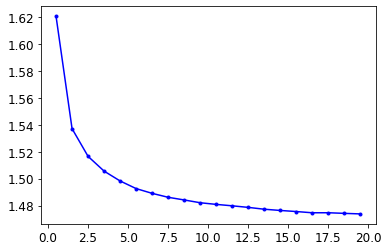

In [13]:
def plot_learning_curves(loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    
plot_learning_curves(history.history["loss"])
plt.show()

In [14]:
def preprocess(texts):
    X = np.array(tokenizer.texts_to_sequences(texts)) - 1
    return tf.one_hot(X, max_id)

In [15]:
X_new = preprocess(["How are yo"])
#Y_pred = model.predict_classes(X_new)
Y_pred = np.argmax(model(X_new), axis=-1)
tokenizer.sequences_to_texts(Y_pred + 1)[0][-1] # 1st sentence, last char

'u'

In [16]:
def next_char(text, temperature=1):
    X_new = preprocess([text])
    y_proba = model(X_new)[0, -1:, :]
    rescaled_logits = tf.math.log(y_proba) / temperature
    char_id = tf.random.categorical(rescaled_logits, num_samples=1) + 1
    return tokenizer.sequences_to_texts(char_id.numpy())[0]

In [17]:
tf.random.set_seed(42)

next_char("How are yo", temperature=1)

'u'

In [18]:
def complete_text(text, n_chars=50, temperature=1):
    for _ in range(n_chars):
        text += next_char(text, temperature)
    return text

In [19]:
tf.random.set_seed(42)

print(complete_text("t", temperature=0.2))

ther will i know my hands.

gremio:
i will not swea


In [33]:
print(complete_text("t", temperature=1))

tokecome
i hear in poble contributoro,
though be al


In [20]:
print(complete_text("t", temperature=2))

tokcc ba
do;'ard.
you jance, crack jolnins! urdelly


In [21]:
print(complete_text("t", temperature=0.25, n_chars=2000))

ther will have the man
and be a scolding of a scolding of my elf,
and so we may be to be to be to her as a scolding of a scolding of a scolding scolding scolding than any offence that she is a sweet scolding of a scolding of a scolding tongue.

tranio:
o this is the matter? what shall i be gone.

grumio:
will i be gone, and my good father is the man
as i shall be a store and beauteous first.

grumio:
master, i will prove the world,
to make a scolding of a scolding of a scolding of a scolding tongue.

tranio:
i shall be so beloved to her to see
and so will be in all the rest,
and therefore that you may be gone.

hortensio:
what, i will not be in a lawful will,
and if you have a scolding of a scolding of the world,
that i may be to be the mand in her thee that a word,
that i may be so beauteous for my elf,
so well i see the world, that i do see thee with a little great and man
and be a suitors to be wooed and best and beauteous face,
and not to make a bind of such a scolding state,
and s